In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#show plots with notebook itself
%matplotlib inline

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import statsmodels.api as sm


#linear regression and mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from pandas import to_datetime


import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')



### Problem Formulation 
We want to forecast the GDP per Capita per country for the next 6 years 

### Load data from csv

In [2]:
raw_data = pd.read_csv("F:\Machine Learning Projects\ARIMA\TimeSeriesForecastGDPRAW.csv.txt", encoding='latin-1')

#rows and columns
print(raw_data.shape)

raw_data.head()

(270038, 8)


,demo,indicator,location,country,time,value,flog codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,NaN,NaN


### Data pre-processing

In [3]:
#check null values
raw_data.isnull().sum()

demo               0
indicator          0
location           0
country            0
time               0
value           2066
flog codes    267972
flags         267972
dtype: int64

In [4]:
#clean null values from values col

raw_data = raw_data.dropna(subset=['value'])

#remove last two columns with null values

raw_data= raw_data[['demo','indicator','location','country','time','value']]

raw_data.isnull().sum()


demo         0
indicator    0
location     0
country      0
time         0
value        0
dtype: int64

In [5]:
#checking unique values in each column

for column in raw_data:
    unique_value = np.unique(raw_data[column])
    unique_sum= len(unique_value)
    
    print('Unique value for feature {} : {}'.format(column,unique_sum))

Unique value for feature demo : 35
Unique value for feature indicator : 35
Unique value for feature location : 233
Unique value for feature country : 233
Unique value for feature time : 50
Unique value for feature value : 125438


In [6]:
#filtering out the data we need - GDP per Capita

forecast_data = raw_data[raw_data['indicator'] == 'GDP per capita, PPP (current international $)']


#filter out some countries

forecast_data = forecast_data[~forecast_data['country'].isin(['Djibouti', 'South Sudan', 'Curaþao', 'Eritrea', 'Bermuda', 'Venezuela (Bolivarian Republic of)'])]

forecast_data.head()




,demo,indicator,location,country,time,value
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990,17333.10
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991,17793.60
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992,18189.34
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993,19130.89
76852,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994,20063.81


In [7]:
#limiting columns we need 

forecast_data= forecast_data[['country','time','value']]
forecast_data.head()


,country,time,value
76848,Australia,1990,17333.10
76849,Australia,1991,17793.60
76850,Australia,1992,18189.34
76851,Australia,1993,19130.89
76852,Australia,1994,20063.81


In [8]:
#change the time to date as most time series models require data structure

# convert into string and upending -01-01
forecast_data['time'] = forecast_data['time'].astype(str) + '-01-01'

forecast_data['time'] = pd.to_datetime(forecast_data['time'])

forecast_data.head()



,country,time,value
76848,Australia,1990-01-01,17333.10
76849,Australia,1991-01-01,17793.60
76850,Australia,1992-01-01,18189.34
76851,Australia,1993-01-01,19130.89
76852,Australia,1994-01-01,20063.81


### Splitting the raw data for training and validation

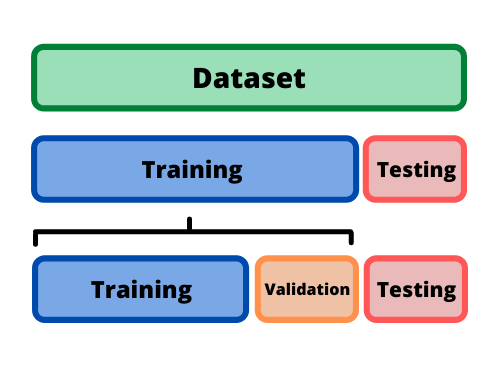

In [9]:
x_train= forecast_data[forecast_data['time'] < '2012-01-01']
x_valid= forecast_data[forecast_data['time'] >= '2012-01-01']


print("X train shape: ",x_train.shape )
print("X validation shape: ",x_valid.shape )


X train shape:  (3967, 3)
X validation shape:  (1133, 3)


### ARIMA for dummies

https://medium.com/analytics-vidhya/arima-for-dummies-ba761d59a051

http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/


In [23]:
#running arima for USA

#filter the train data


us = x_train[x_train['country'] == 'United States of America']
us2 = us[['time', 'value']]

#filter valid data

us_v = x_valid[x_valid['country'] == 'United States of America']
us_v2 = us_v[['time', 'value']]


#set date to index -- need to do this to run time series model

us2.set_index('time', inplace=True)
us_v2.set_index('time', inplace=True)


# Setting the Index for 6 years going fwd-- use this as forecasting input later

#AS== annual frequency

index_6_years = pd.date_range(us2.index[-1], freq='AS', periods = 6) 




In [24]:
index_6_years

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

MSE of arima:  5397.410381685327


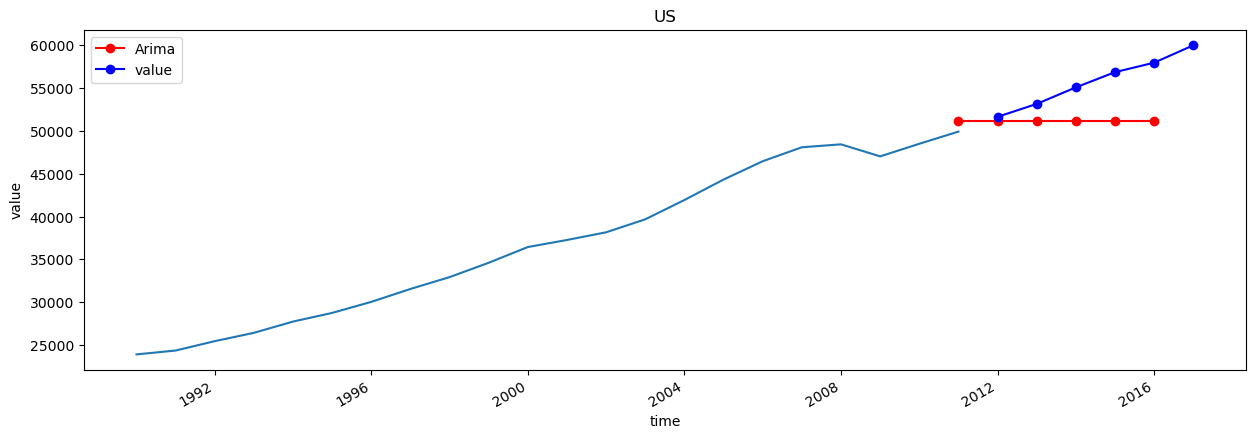

In [25]:
#running arima with random p,d,q


model_arima = sm.tsa.arima.ARIMA(us2, order=(0,2,2))  #random 3 values pdq
model_arima_fit= model_arima.fit()


#making predictions on the 6 year index without index first
fcast1= model_arima_fit.forecast(6)[0]
    
    
# Passing the index
fcast1 = pd.Series(fcast1, index=index_6_years)
fcast1 = fcast1.rename("Arima") 


# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='time', y='value', data = us)
chart.set_title('US')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
us_v2.plot(ax=ax, color='blue', marker="o", legend=True)


#mean square error -- average squared difference between observed vs predicted
#tells us by how much $ our prediction is off by
#smaller mse = better performance


print("MSE of arima: ",mean_squared_error(us_v['value'].values, fcast1.values, squared=False))


In [20]:
#Finding the best value for ARIMA

import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = sm.tsa.arima.ARIMA(us2,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better



(0, 0, 0) 465.35519121364865
(0, 0, 1) 442.10335575704977
(0, 0, 2) 423.6530886222216
(0, 0, 3) 409.49085017599486
(0, 0, 4) 399.5953107007465
(0, 1, 0) 367.6818884312621
(0, 1, 1) 367.1778814750186
(0, 1, 2) 368.0302385558524
(0, 1, 3) 368.7406115220174
(0, 1, 4) 367.8316492551027
(0, 2, 0) 330.6658279231679
(0, 2, 1) 332.1005246169557
(0, 2, 2) 333.53340729938327
(0, 2, 3) 334.2158067422346
(0, 2, 4) 336.1484711582316
(0, 3, 0) 330.430558885525
(0, 3, 1) 323.3196440386799
(0, 3, 2) 324.41994346154263
(0, 3, 3) 326.3098332137132
(0, 3, 4) 327.48310215178475
(0, 4, 0) 331.7434806012843
(0, 4, 1) 317.55936234444556
(0, 4, 2) 313.12030072316213
(0, 4, 3) 314.75071490241595
(0, 4, 4) 315.4030375750033
(1, 0, 0) 393.35117173012003
(1, 0, 1) 380.7392813062825
(1, 0, 2) 379.103170906375
(1, 0, 3) 425.1519848341959
(1, 0, 4) 378.8280862927762
(1, 1, 0) 366.3684203803191
(1, 1, 1) 346.8069172025968
(1, 1, 2) 348.74188163458615
(1, 1, 3) 350.6224198060331
(1, 1, 4) 351.5023376236766
(1, 2, 0) 3

### Running ARIMA for future predictions

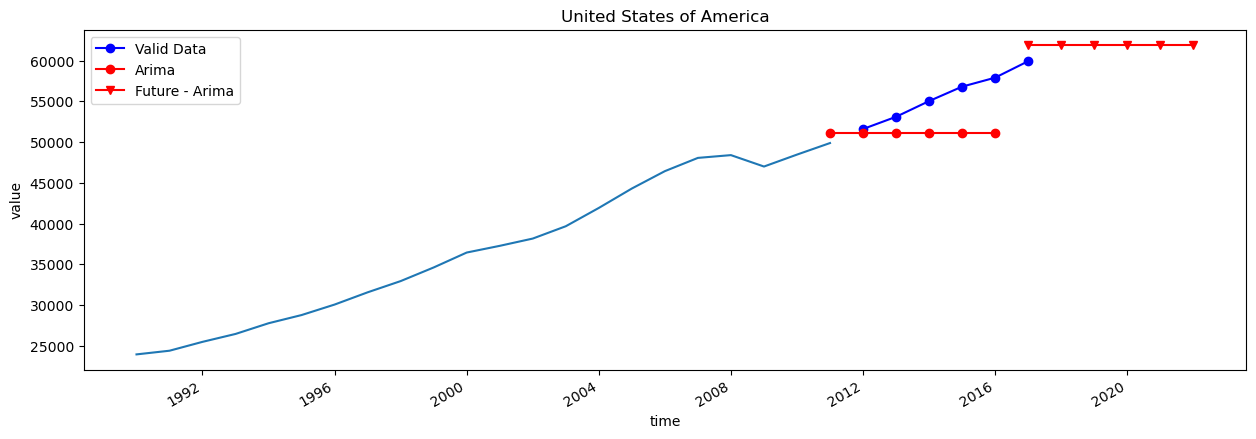

In [26]:
# creating a country list
countries = forecast_data['country'].unique()

countries = ['United States of America']


for c in countries:
    # filtering the train data - USA
    train_data =  x_train[x_train['country'] == c] 
    train_data2 = train_data[['time', 'value']] 
    
    # filtering the valid data  - USA
    valid_data = x_valid[x_valid['country'] == c]
    valid_data2 = valid_data[['time', 'value']]
    
    # all data  - USA
    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]
    
    
    #convert date column to datetime for train and valid and all data
    train_data2.set_index('time', inplace=True)
    valid_data2.set_index('time', inplace=True)
    valid_data2.columns = ['Valid Data']    #rename -- need to see this
    all_data2.set_index('time', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_6_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 6) 
    
    # Setting the Future - Index for 6 years
    future_index_6_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 6) 
    
    
    # Dropping all tables for checking for other countries -- when in loop
    try:
        del t_fcast1
        
        
    except:
        print("")

   
        
        
        
        #########################################   ARIMA   ########################################
        
        #VALIDATION
        
    try:        
        try:
            # Running ARIMA on Best parameter 1
            model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,2))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_6_years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on Best parameter 2
            model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,0))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_6_years)
            t_fcast1 = t_fcast1.rename("Arima") 
    
    except:
            print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter 1
            model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,2))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_6_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    
        except:
            # Running ARIMA on Best parameter 2
            model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,0))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_6_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 

        
    except:
            print(c, "Arima Future Error")   
            
            
            
            
            
            
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='time', y='value', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
  
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
   
    


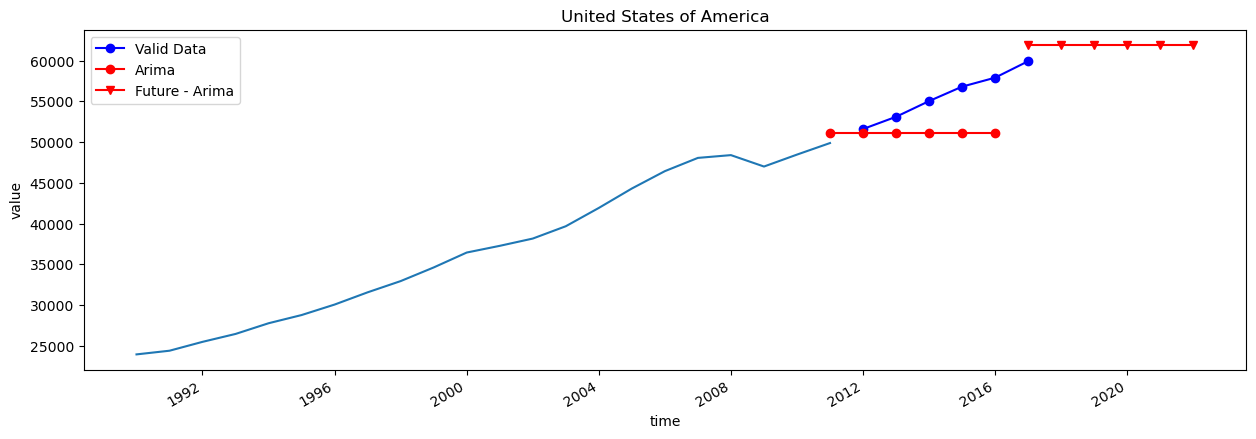

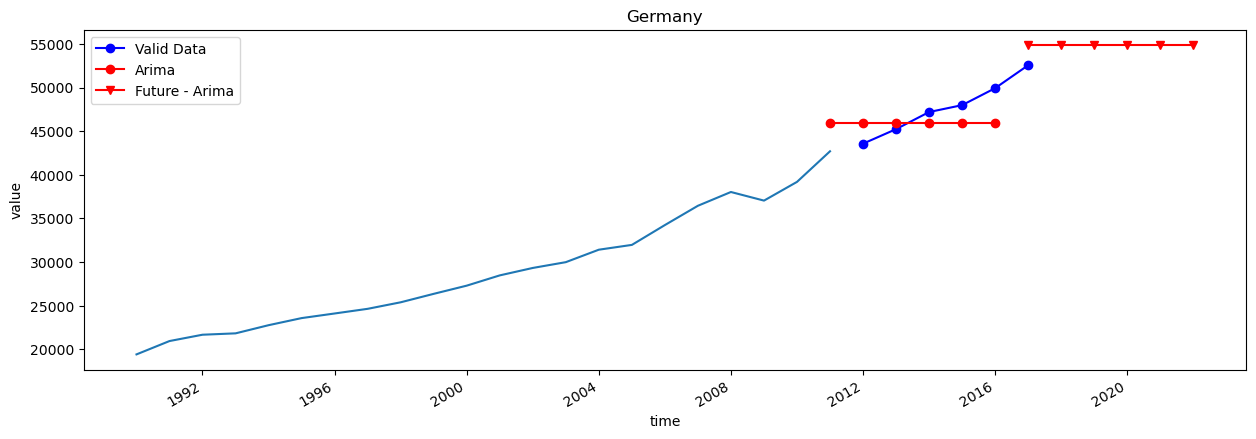

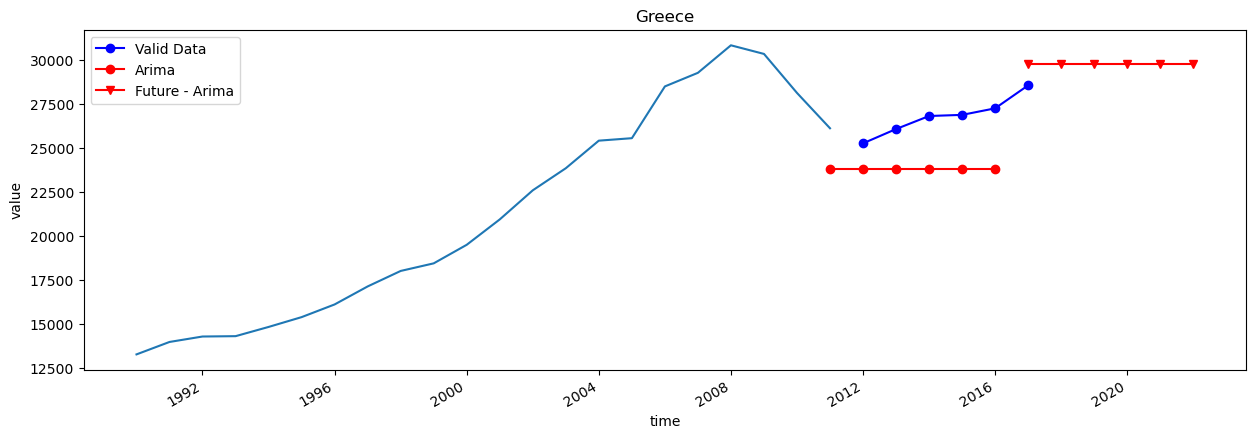

In [28]:
# creating a country list
countries = forecast_data['country'].unique()


#for three countries

countries = ['United States of America',"Germany","Greece"]


for c in countries:
    # filtering the train data - USA
    train_data =  x_train[x_train['country'] == c] 
    train_data2 = train_data[['time', 'value']] 
    
    # filtering the valid data  - USA
    valid_data = x_valid[x_valid['country'] == c]
    valid_data2 = valid_data[['time', 'value']]
    
    # all data  - USA
    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]
    
    
    #convert date column to datetime for train and valid and all data
    train_data2.set_index('time', inplace=True)
    valid_data2.set_index('time', inplace=True)
    valid_data2.columns = ['Valid Data']    #rename -- need to see this
    all_data2.set_index('time', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_6_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 6) 
    
    # Setting the Future - Index for 6 years
    future_index_6_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 6) 
    
    
    # Dropping all tables for checking for other countries -- when in loop
    try:
        del t_fcast1
        
        
    except:
        print("")

   
        
        
        
        #########################################   ARIMA   ########################################
        
        #VALIDATION
        
    try:        
        try:
            # Running ARIMA on Best parameter 1
            model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,2))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_6_years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on Best parameter 2
            model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,0))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_6_years)
            t_fcast1 = t_fcast1.rename("Arima") 
    
    except:
            print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter 1
            model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,2))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_6_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    
        except:
            # Running ARIMA on Best parameter 2
            model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,0))
            model_arima_fit = model_arima.fit()

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(6)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_6_years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 

        
    except:
            print(c, "Arima Future Error")   
            
            
            
            
            
            
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='time', y='value', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
  
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
   
    

In [29]:
from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(valid_data2, t_fcast1)
print(f'MAPE: {mape_value:.2f}%')

MAPE: 10.98%


## Notes

make sure that series is stationary and there is no seasonality. if it is not stationery make it by differencing. 
We can subtract the sales data for each month from the sales data for the previous month to remove the trend
ADf test can show if the series is stationery or not.if p value>0.05 then apply differencing 

decide the hyper parameters for arima fit(p,d,q)
PACf gives AR == p
ACf gives MA values == q
these values depends on the spikes and gradual decay

In ARIMA modeling, AIC stands for Akaike Information Criterion. It is a measure of the relative quality of a statistical model for a given set of data. AIC provides a way to compare different models with different numbers of parameters, and choose the one that best balances the trade-off between model fit and model complexity.

The AIC value is calculated as:

AIC = 2k - 2ln(L)

where k is the number of parameters in the model and L is the likelihood function of the model. The AIC value is a scalar, and the lower the AIC value, the better the model is considered to fit the data.

In ARIMA modeling, AIC is often used as a criterion for selecting the optimal values of the ARIMA parameters (p,d,q) that provide the best fit to the data. The idea is to fit a range of ARIMA models with different parameter combinations, and choose the one with the lowest AIC value as the best model.

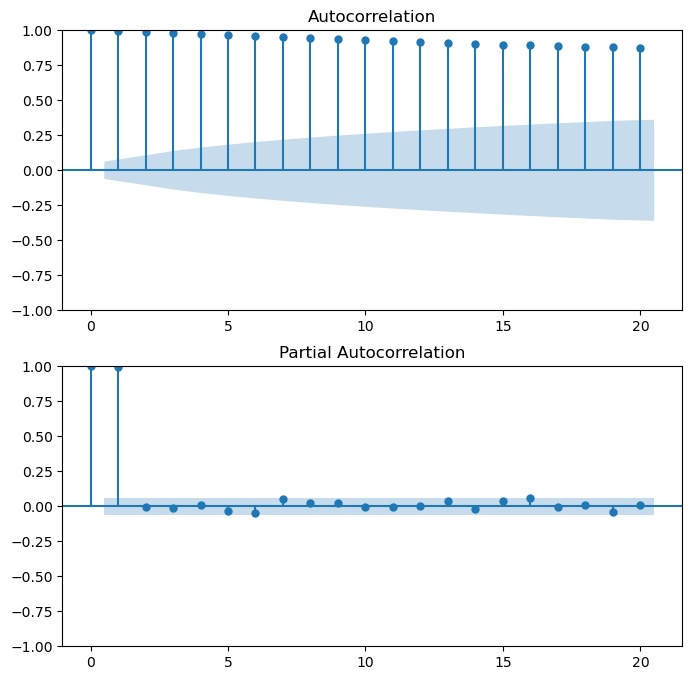

In [32]:
#sample example for ACF and PACF

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# generate a demo time series
np.random.seed(123)
data = pd.Series(np.random.randn(1000).cumsum())

# plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(data, ax=ax1, lags=20)
plot_pacf(data, ax=ax2, lags=20)
plt.show()

In this example, we first generate a demo time series using the cumsum() method to create a random walk. We then use the plot_acf() and plot_pacf() functions from the statsmodels.graphics.tsaplots module to generate the ACF and PACF plots, respectively.

The resulting ACF and PACF plots should look something like this:

ACF and PACF demo plot

In this example, the ACF plot shows a gradual decay over time, indicating that the time series may be stationary. The PACF plot shows a significant spike at lag 1 and some smaller spikes at higher lags, suggesting that an AR(1) model may be appropriate for this time series. However, because this is a demo time series, the results may not be representative of a real-world time series.


And what about the ma value?
To determine the appropriate value of q for the MA component of the ARIMA model, you can look at the PACF plot. The partial autocorrelation function (PACF) measures the correlation between the series and its lagged values after controlling for the effects of all lower-order lags.

If the PACF plot has a sharp drop after lag q, it suggests that there may be a significant correlation between the series and its lagged values up to lag q, and that a MA(q) model may be appropriate.

In the demo plot example I showed earlier, the PACF plot shows some small spikes after lag 1, but no significant spike. This suggests that an MA model may not be necessary for this time series, or that a low value of q may be sufficient.

Keep in mind that the ACF and PACF plots are just a starting point, and other factors such as the stationarity and seasonality of the time series should also be considered when selecting the appropriate values of p, d, and q.